Okay so the point of this notebook was to make a series of pfn models in different ranges of eta. I had to combine the data processing code from max as well as the actual running-the-model code. This one's a bit tidier than the first one cause I made a couple functions, but this still required me to re-run the eta range and re define X and Y everytime, so wasn't super optimal. Also the functions in this code don't return everything I would need - if I keep the predictions within that function then fp, tp, auc, all need to be SAVED within that function so I don't have to do what I tried to do at the end of this notebook (trying to re-load all the models so I could compute the roc curves, eyeroll). As well as saving the model, and these, then, might as well save x ant y test so these wouldn't have to be re-computed when using the saved model again? or save the model history somehow? anyway

anyway all that was to say that there are two more week 5 notebooks which are continuations of this (part 2 and roc), see these for reloading the models and then for producing the comparison roc curve as well respectively

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

In [3]:
#first: data processing: (careful she takes a long time)
path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'

tree_pipm = ur.open(path_pipm)['EventTree']
tree_pi0  = ur.open(path_pi0)['EventTree']

geoDict_tree_pipm = ur.open(path_pipm)['CellGeo']
geoDict_tree_pi0  = ur.open(path_pi0)["CellGeo"]

cell_id_pipm = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pipm, 2000)
cell_e_pipm = gu.loadArrayBranchFlat('cluster_cell_E', tree_pipm, 2000)
cell_id_pi0 = gu.loadArrayBranchFlat('cluster_cell_ID', tree_pi0, 2000)
cell_e_pi0 = gu.loadArrayBranchFlat('cluster_cell_E', tree_pi0, 2000)

geoDict_pipm = gu.loadGraphDictionary(geoDict_tree_pipm)
geoDict_pi0  = gu.loadGraphDictionary(geoDict_tree_pi0)

cell_phi_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_phi', geoDict_pipm)
cell_eta_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_eta', geoDict_pipm)
cell_phi_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_phi', geoDict_pi0)
cell_eta_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_eta', geoDict_pi0)

clus_eta_pipm = gu.loadVectorBranchFlat('cluster_Eta', tree_pipm)
clus_E_pipm = gu.loadVectorBranchFlat('cluster_E', tree_pipm)

clus_eta_pi0 = gu.loadVectorBranchFlat('cluster_Eta', tree_pi0)
clus_E_pi0 = gu.loadVectorBranchFlat('cluster_E', tree_pi0)

clus_phi_pipm = gu.loadVectorBranchFlat('cluster_Phi', tree_pipm)
clus_phi_pi0  = gu.loadVectorBranchFlat('cluster_Phi', tree_pi0)

In [4]:
#HERE: change the eta cuts!
eta_mask_pipm = (abs(clus_eta_pipm) > 2.5) & (abs(clus_eta_pipm) < 3.1)
eta_mask_pi0  = (abs(clus_eta_pi0) > 2.5) & (abs(clus_eta_pi0) < 3.1)

energy_mask_pipm = clus_E_pipm > 0.5
energy_mask_pi0 = clus_E_pi0 > 0.5

selection_pipm = eta_mask_pipm & energy_mask_pipm
selection_pi0 = eta_mask_pi0 & energy_mask_pi0

eta_mask_pipm[:10], clus_eta_pipm[:10] #okay good that works jeez lol

(array([False, False, False, False, False, False, False, False, False,
        False]),
 array([-1.125384  , -0.9594247 ,  0.93537796, -1.9522849 ,  1.1632881 ,
        -0.06523713, -0.05172568, -0.09848271, -0.03274849,  1.0723295 ],
       dtype=float32))

In [5]:
#dont rerun
cell_eta_norm_pipm = np.nan_to_num(cell_eta_pipm - clus_eta_pipm[:, None])
cell_eta_norm_pi0 = np.nan_to_num(cell_eta_pi0 - clus_eta_pi0[:, None])
cell_phi_norm_pipm = np.nan_to_num(cell_phi_pipm - clus_phi_pipm[:, None])
cell_phi_norm_pi0 = np.nan_to_num(cell_phi_pi0 - clus_phi_pi0[:, None])

cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)

# Working after some careful manipulation of the masks
cell_samp_pipm = gu.convertIDToGeo(cell_id_pipm, 'cell_geo_sampling', geoDict_pipm)
cell_samp_pi0 = gu.convertIDToGeo(cell_id_pi0, 'cell_geo_sampling', geoDict_pi0)

#normalize to a lower value fairly arbitrarily
cell_samp_norm_pipm = cell_samp_pipm * 0.1
cell_samp_norm_pi0 = cell_samp_pi0 * 0.1


<ipython-input-5-9ca06993e40d>:7: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pipm = np.nan_to_num(np.log(cell_e_pipm), posinf = 0, neginf=0)
<ipython-input-5-9ca06993e40d>:8: RuntimeWarning: divide by zero encountered in log
  cell_e_norm_pi0 = np.nan_to_num(np.log(cell_e_pi0), posinf = 0, neginf=0)


In [6]:
#rerun!!!
X_pipm = np.stack((cell_e_norm_pipm[selection_pipm], cell_eta_norm_pipm[selection_pipm], cell_phi_norm_pipm[selection_pipm], cell_samp_norm_pipm[selection_pipm]), axis = 2)
X_pi0  = np.stack((cell_e_norm_pi0[selection_pi0], cell_eta_norm_pi0[selection_pi0], cell_phi_norm_pi0[selection_pi0], cell_samp_norm_pi0[selection_pi0]), axis = 2)

len(X_pipm), len(X_pi0)

(39324, 36328)

In [7]:
#rerun with appropriate size! note not saving these cause they're way too big:/
X = np.concatenate((X_pipm[:36000], X_pi0[:36000]))
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(36000), np.zeros(36000)))) #one hot
print(len(X), len(Y))
#np.save('./X_l05.npy', X)

72000 72000


Now onto the pfn

In [8]:
def modelNmetrics(X, Y, test_size, model_name):
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X), 'Y: ', len(Y), 'test: ', test_size)
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=test_size)

    #make the model:
    pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)
    
    # train model
    history = pfn.fit(X_train, Y_train, epochs=100, batch_size=500, validation_data=(X_val, Y_val), verbose=1)
    
    preds = pfn.predict(X_test, batch_size=1000)
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print('PFN AUC:', auc)
    pfn.save('./pfnmodel_{}.h5'.format(model_name))

    return history, pfn_fp, pfn_tp

In [9]:
def plots(history, pfn_fp, pfn_tp):
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,100)
    ax1.plot(history.history['acc'], label='training set', c='xkcd:butterscotch', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:coffee', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,100)
    ax2.plot(history.history['loss'], label='training set', c='xkcd:dull brown', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:taupe', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()
    
    plt.figure(figsize=[7,7])
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(pfn_fp, pfn_tp, c='xkcd:dirt', linewidth=4)
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')

In [22]:
history_l05, fp_l05, tp_l05 = modelNmetrics(X, Y, 20000, 'l05')

sizes: X  130000 Y:  130000 test:  20000
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
___________________________________________________

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



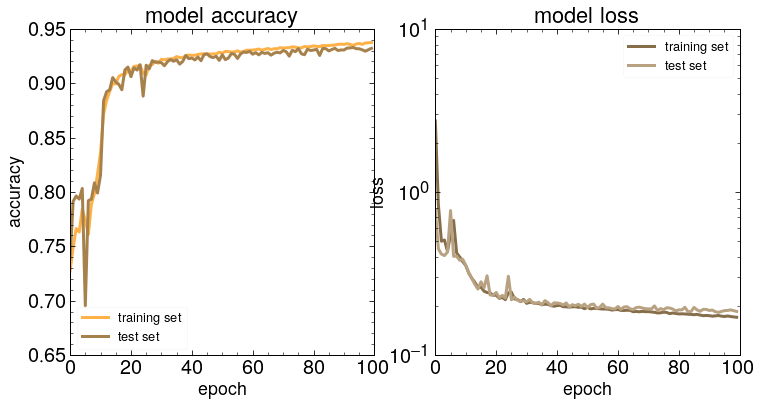

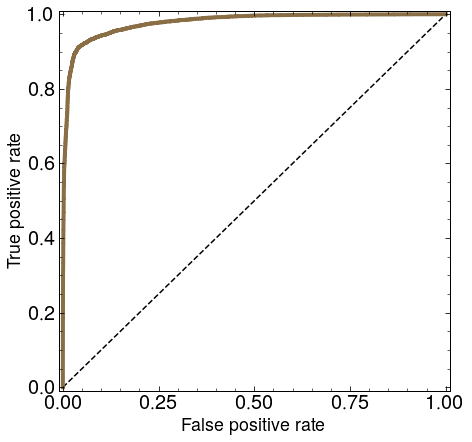

In [25]:
plots(history_l05, fp_l05, tp_l05)

In [35]:
history_l07, fp_l07, tp_l07 = modelNmetrics(X, Y, 40000, 'l07')

sizes: X  180000 Y:  180000 test:  40000
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
___________________________________________________

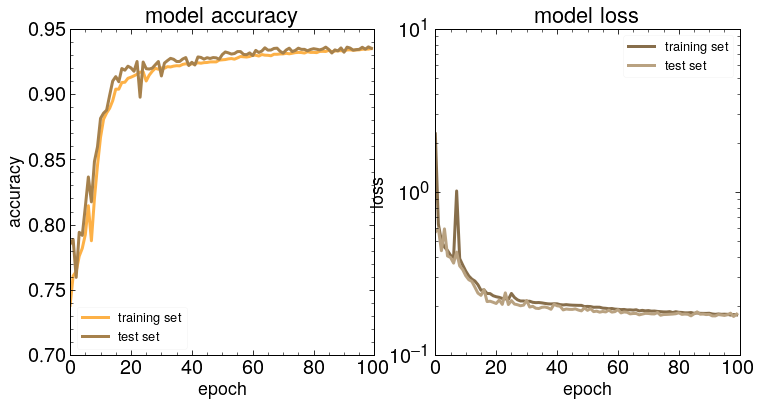

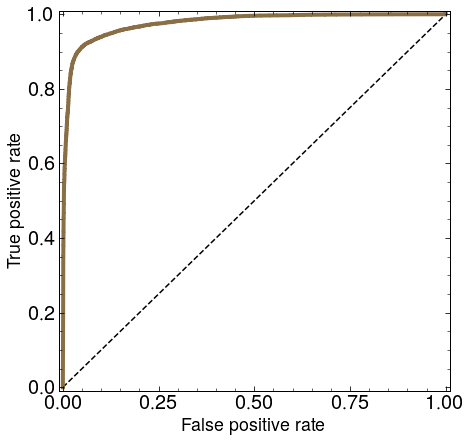

In [36]:
plots(history_l07, fp_l07, tp_l07)

In [40]:
# for eta between 0.7 and 1.5:
history_0715, fp_b0715, tp_b0715 = modelNmetrics(X, Y, 40000, 'b0715')

sizes: X  180000 Y:  180000 test:  40000
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]              
___________________________________________________

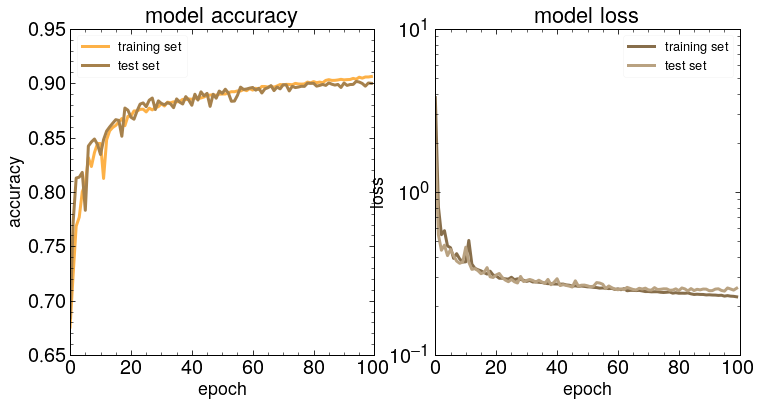

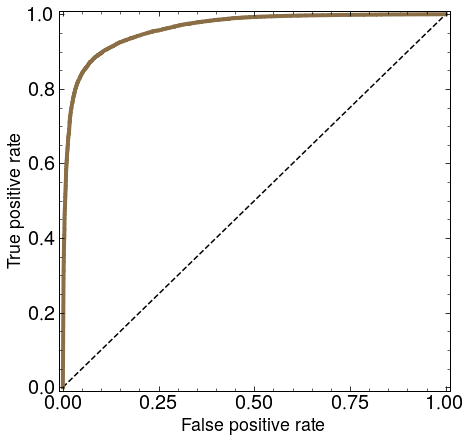

In [41]:
plots(history_0715, fp_b0715, tp_b0715)

In [45]:
# for eta greater than 1.5:
history_g15, fp_g15, tp_g15 = modelNmetrics(X, Y, 40000, 'g15')

sizes: X  180000 Y:  180000 test:  40000
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_35 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_35[0][0]              
___________________________________________________

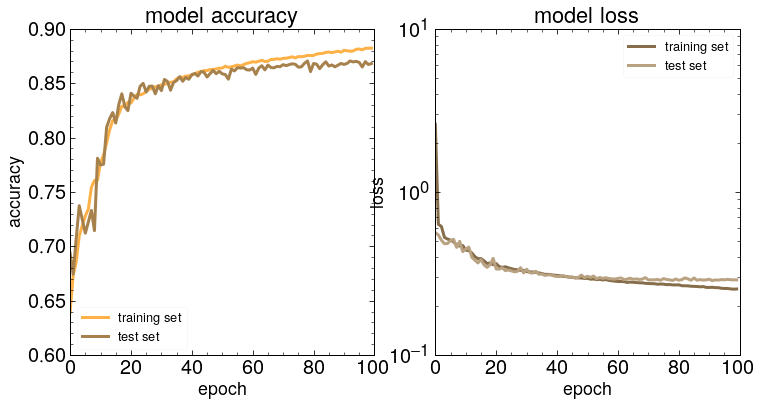

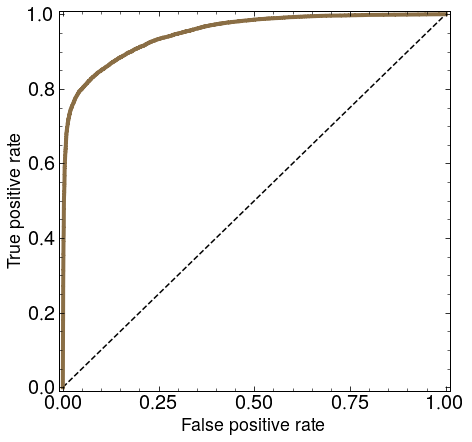

In [47]:
plots(history_g15, fp_g15, tp_g15)

In [10]:
# for all eta :  this does not do better than eta < .7
history_all, fp_all, tp_all = modelNmetrics(X, Y, 40000, 'gall')

sizes: X  180000 Y:  180000 test:  40000
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
_____________________________________________________

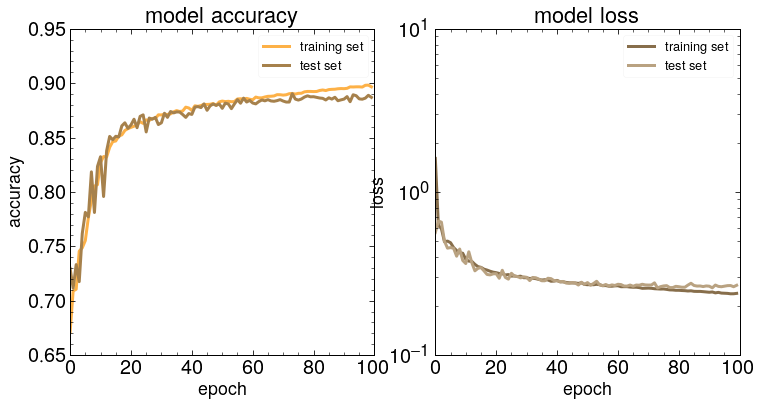

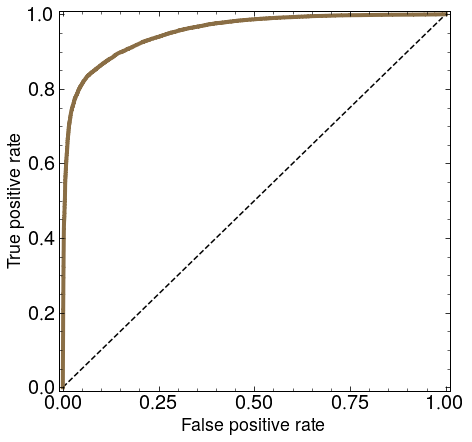

In [11]:
plots(history_all, fp_all, tp_all)

In [16]:
# for eta < 1.5
history_l15, fp_l15, tp_l15 = modelNmetrics(X, Y, 40000, 'l15')#not better than <.7

sizes: X  180000 Y:  180000 test:  40000
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
___________________________________________________

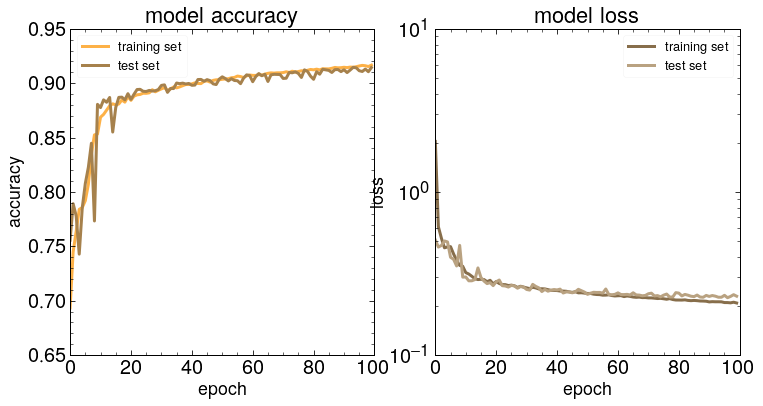

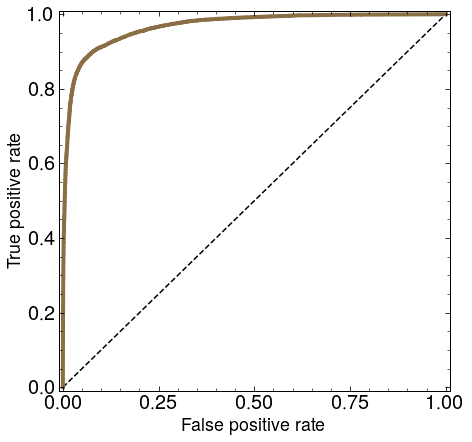

In [17]:
plots(history_l15, fp_l15, tp_l15)

In [21]:
history_l1, fp_l1, tp_l1 = modelNmetrics(X, Y, 40000, 'l1') #for eta less than 1

sizes: X  180000 Y:  180000 test:  40000
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
___________________________________________________

In [39]:
history_l1[0], history_l15

(<tensorflow.python.keras.callbacks.History at 0x7f60395c3220>,
 <tensorflow.python.keras.callbacks.History at 0x7f5afc7abb20>)

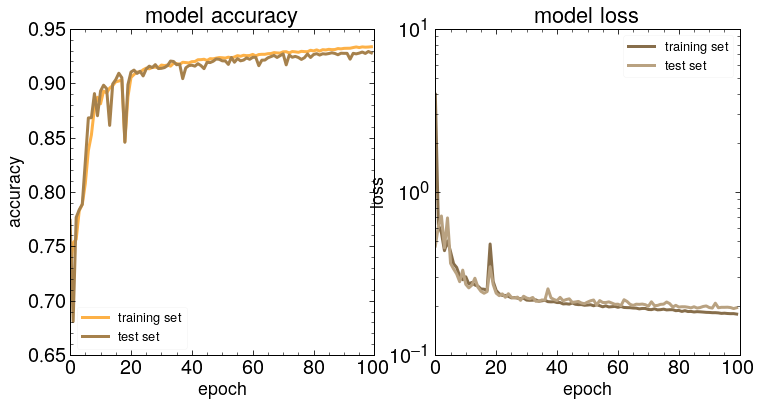

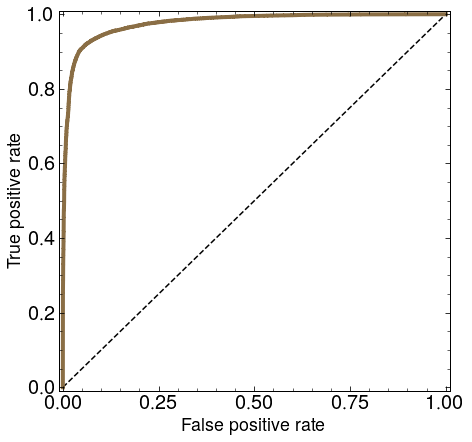

In [22]:
plots(history_l1, fp_l1, tp_l1)

In [26]:
#also try: 0-1.4, 1.4-2.5, 2.5-3.1, 3.1+ bc these are the different detector sections I think based on that graphic

#1.4 - 2.5

history_b1425, fp_b1425, tp_b1425 = modelNmetrics(X, Y, 40000, 'b1425')

sizes: X  180000 Y:  180000 test:  40000
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
___________________________________________________

In [10]:
models_b1425 = tf.keras.models.load_model('./pfnmodel_b1425.h5')
plots(history_b1425, fp_b1425, tp_b1425) #did I save it wrong??? Idk what's going on here...

NameError: name 'history_b1425' is not defined

In [19]:
models_b1425.history.history['acc']

KeyError: 'acc'

In [21]:
history_2531, fp_b2531, tp_b2531 = modelNmetrics(X, Y, 15000, 'b2531') #uh oh this one wont work either probably 3.1+ wont either

sizes: X  72000 Y:  72000 test:  15000
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
_______________________________________________________

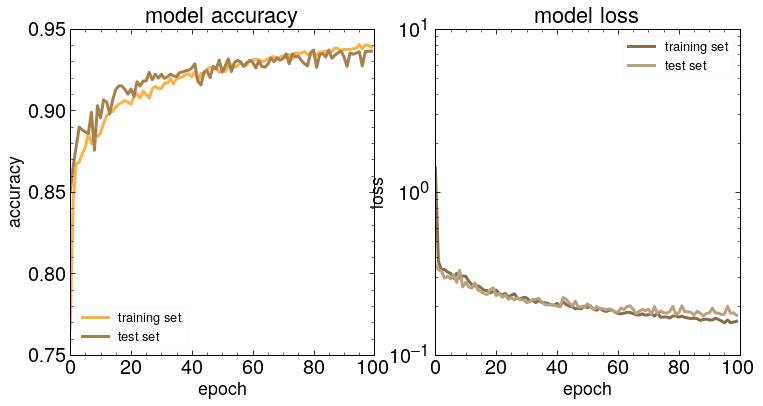

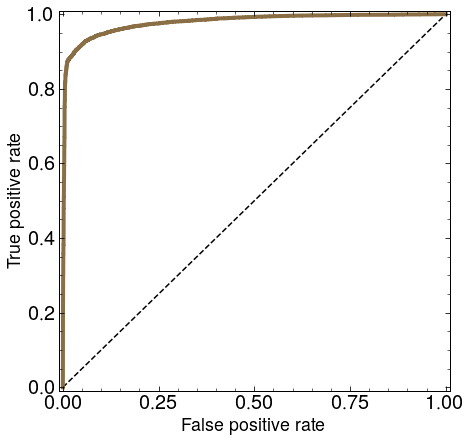

In [22]:
plots(history_2531, fp_b2531, tp_b2531)

In [23]:
def compiled_rocs(X, Y, model, test_size):
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=test_size)

    preds = model.predict(X_test, batch_size=1000)
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    
    return pfn_fp, pfn_tp, auc #instead of doing this I should definitely just return these when making the model
                               #so defs make that change once they improve models/data/etc !!

In [ ]:
eta_mask_pipm = abs(clus_eta_pipm) < 1.#(abs(clus_eta_pipm) > .7) | (abs(clus_eta_pipm) < 1.5)
eta_mask_pi0  = abs(clus_eta_pi0) < 1.#(abs(clus_eta_pi0) > .7) | (abs(clus_eta_pi0) < 1.5)

energy_mask_pipm = clus_E_pipm > 0.5
energy_mask_pi0 = clus_E_pi0 > 0.5

selection_pipm = eta_mask_pipm & energy_mask_pipm
selection_pi0 = eta_mask_pi0 & energy_mask_pi0

X_pipm = np.stack((cell_e_norm_pipm[selection_pipm], cell_eta_norm_pipm[selection_pipm], cell_phi_norm_pipm[selection_pipm], cell_samp_norm_pipm[selection_pipm]), axis = 2)
X_pi0  = np.stack((cell_e_norm_pi0[selection_pi0], cell_eta_norm_pi0[selection_pi0], cell_phi_norm_pi0[selection_pi0], cell_samp_norm_pi0[selection_pi0]), axis = 2)

len(X_pipm), len(X_pi0)

In [ ]:
X = np.concatenate((X_pipm[:90000], X_pi0[:90000]))
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000)))) #one hot
print(len(X), len(Y))

In [28]:
fp_b1425, tp_b1425, auc_b1425 = compiled_rocs(X, Y, models_b1425, 40000)

In [30]:
models_l05 = tf.keras.models.load_model('./pfnmodel_l05.h5')

In [33]:
fp_l05, tp_l05, auc_l05 = compiled_rocs(X, Y, models_l05, 20000)

In [34]:
models_l07 = tf.keras.models.load_model('./pfnmodel_l07.h5')

In [37]:
fp_l07, tp_l07, auc_l07 = compiled_rocs(X,Y, models_l07, 40000)

In [38]:
models_b0715 = tf.keras.models.load_model('./pfnmodel_b0715.h5')

In [42]:
fp_b0715, to_b0715, auc_b0715 = compiled_rocs(X,Y, models_b0715, 40000)

In [44]:
models_g15 = tf.keras.models.load_model('./pfnmodel_g15.h5')

In [47]:
fp_g15, tp_g15, auc_g15 = compiled_rocs(X,Y, models_g15, 40000)

In [48]:
models_all = tf.keras.models.load_model('./pfnmodel_gall.h5')

In [ ]:
fp_all, tp_all, auc_all = compiled_rocs(X, Y, models_all, 40000)

In [53]:
models_l15 = tf.keras.models.load_model('./pfnmodel_l15.h5')

In [54]:
fp_l15, tp_l15, auc_l15 = compiled_rocs(X, Y, models_l15, 40000)

In [55]:
models_l1 = tf.keras.models.load_model('./pfnmodel_l1.h5')

In [ ]:
fp_l1, tp_l1, auc_l1 = compiled_rocs(X, Y, models_l1, 40000)